### MasaCtrl: Tuning-free Mutual Self-Attention Control for Consistent Image Synthesis and Editing

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import numpy as np

from diffusers import DDIMScheduler, StableDiffusionPipeline
from diffusers.utils.torch_utils import randn_tensor
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-14 08:05:05.298004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 08:05:06.574014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Model Construction

In [2]:
# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model_path = "xyn-ai/anything-v4.0"
model_path = "/hy-tmp/SD2-1-base"
# model_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    custom_pipeline="/hy-tmp/MyREMOVAL/pipeline_mine_refine_inversion.py",
    #custom_pipeline="/hy-tmp/MyREMOVAL/pipeline_mine_refine.py",
    torch_dtype=torch.float16
)
pipe = pipe.to(device)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
/root/.cache/huggingface/modules/diffusers_modules/local/pipeline_mine_refine_inversion.py:203: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub

In [3]:
""" #freeU
from free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d
register_free_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)
register_free_crossattn_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2) """

' #freeU\nfrom free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d\nregister_free_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)\nregister_free_crossattn_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2) '

In [26]:
from masactrl.masactrl import MutualSelfAttentionControlMask_An, MutualSelfAttentionControlMask_An_aug,MutualSelfAttentionControlMask_An_opt
from torchvision.io import read_image
from torchvision.transforms.functional import gaussian_blur

def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(torch.float16).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512))
    mask = gaussian_blur(mask, kernel_size=(13, 13))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(torch.float16).to(device)
    return mask

seed = 777
seed_everything(seed)
generator=torch.Generator("cuda").manual_seed(seed)
sample = "dog" 
out_dir = f"./workdir/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
#out_dir = os.path.join(out_dir, "40")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"/hy-tmp/MyREMOVAL/examples/img/{sample}.png"
MASK_PATH = f"/hy-tmp/MyREMOVAL/examples/mask/{sample}_mask.png"
#SOURCE_IMAGE_PATH = "/home/user01/AnonymousEditing/examples/img/an.png"
#MASK_PATH = "/home/user01/AnonymousEditing/examples/mask/an_mask.png"
#source_image = load_image("/hy-tmp/6000_outputs/fd65d2814b420c84_m01pns0_f7f4b0e6.png", device) #g2
#source_image = load_image("/hy-tmp/6000_outputs/732320891b071e3f_m02wbtzl_10ba47c0.png", device) #
#source_image = load_image("/hy-tmp/6000_outputs/b243906ab6112f4e_m0fszt_76a33150.png", device) 
#source_image = load_image("/hy-tmp/6000_outputs/3635c19d51895f11_m06msq_ef114c7e.png", device) #fff
#source_image = load_image("/hy-tmp/6000_outputs/5668a0cf388d0759_m0h2r6_4555b191.png", device) # car
#source_image = load_image("/hy-tmp/6000_outputs/6278cd96647c442d_m050k8_87034036.png", device) #phone
#source_image = load_image("/hy-tmp/6000_outputs/a6d7562694eba880_m034c16_2af1766e.png", device) #zhentou
#source_image = load_image("/hy-tmp/6000_outputs/a6d7562694eba880_m034c16_f939b3c4.png", device) #zhentou1
#source_image = load_image("/hy-tmp/6000_outputs/3205bdb5bf767046_m04dr76w_8cfcb545.png", device) #lipstick
#source_image = load_image("/hy-tmp/6000_outputs/9933e62312152786_m02zvsm_41cf53a5.png", device) #
#source_image = load_image("/hy-tmp/6000_outputs/155b09c9570670f3_m09728_575e1690.png", device) #bin
#source_image = load_image("/hy-tmp/6000_outputs/85ec9925d7891e25_m015wgc_41b4d91d.png", device) #yangjiao
#source_image = load_image("/hy-tmp/6000_outputs/b5e79249f8151459_m01yrx_775722c0.png", device) #cat
#ource_image = load_image("/hy-tmp/6000_outputs/b7ac9c6bcfe0ff4e_m09728_6e1b66f8.png", device) #ff
#source_image = load_image("/hy-tmp/6000_outputs/aa477c2ba30dba64_m0mcx2_ebe07ee4.png", device) #
#source_image = load_image("/hy-tmp/6000_outputs/060e7b807f03532b_m0cn6p_04632f7e.png", device) #dog
#source_image = load_image("/hy-tmp/6000_outputs/0c41a8fe6bf2f06c_m0242l_742e3a90.png", device) #f_coin
#source_image = load_image("/hy-tmp/6000_outputs/a84baa836bffe1bf_m014j1m_0d1315c9.png", device) #apple
#source_image = load_image("/hy-tmp/6000_outputs/a4083d834a1564de_m029b3_3c38effc.png", device) #shaizi
#source_image = load_image("/hy-tmp/6000_outputs/ac2dccf79a85cc51_m09728_bfac9444.png", device) #g1
#source_image = load_image("/hy-tmp/6000_outputs/c2b8e5978146d18e_m03bt1vf_b089318d.png", device) #huabing
#source_image = load_image("/hy-tmp/DATA/sample/cfc13f689bc316fe_m03bt1vf_c8041a04.jpg", device) # all_layer
#source_image = load_image("/hy-tmp/DATA/sample/ea899b6131fae4a4_m06msq_da19c7aa.jpg", device) #g2
#source_image = load_image("/hy-tmp/DATA/sample/62e2c99d9cc1e889_m0ch_cf_a40824f4.jpg", device) #g3
#source_image = load_image("/hy-tmp/DATA/sample/2847b40c81780f47_m01bl7v_d04147c9.jpg", device) #g4
#source_image = load_image("/hy-tmp/DATA/sample/3c27666c417ee021_m01b638_0bd5b23a.jpg", device) #xiezi
source_image = load_image("/hy-tmp/DATA/sample/0a9fd00665d365a8_m05r655_4bc6f8bf.jpg", device) #
#/hy-tmp/powerpaint_output_total/646ced68ebe371a1_m0jly1_6a0cebbf_power_123.png
mask = load_mask("/hy-tmp/DATA/sample/0a9fd00665d365a8_m05r655_4bc6f8bf_mask.png", device)
#/hy-tmp/DATA/sample/62cfa0c7bd8e38b6_m029b3_fd6e030a.jpg
#source_image = load_image(SOURCE_IMAGE_PATH, device)
#mask = load_mask(MASK_PATH, device)


In [27]:
source_prompt = ""
target_prompt = ""
prompts = [source_prompt, target_prompt]
with torch.no_grad():
    # invert the source image
    #start_code, x0 = pipe.invert(
    start_code, latents_list = pipe.invert(
                                source_image,
                                mask,
                                source_prompt,
                                generator=generator,
                                guidance_scale=1,
                                num_inference_steps=50,
                                return_intermediates=True)

In [28]:
"""  # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(pred_x0_list[30:40][i])
    ax.axis('off')  # 隐藏坐标轴

plt.show()  """

"  # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)\nfig, axs = plt.subplots(2, 5, figsize=(15, 6))\n\nfor i, ax in enumerate(axs.flatten()):\n    ax.imshow(pred_x0_list[30:40][i])\n    ax.axis('off')  # 隐藏坐标轴\n\nplt.show()  "

In [29]:
#inversion based
START_STEP = 0
END_STEP = 50
LAYER = 0 #0~5down,6mid,7~15up
END_LAYER = 16
removelist=[6]
layer_idx=list(range(LAYER, END_LAYER))

for i in removelist:
    layer_idx.remove(i)
# hijack the attention module
editor = MutualSelfAttentionControlMask_An_opt(START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask)
regiter_attention_editor_diffusers(pipe, editor)
#image, pred_x0_list_denoise, latents_list_denoise = pipe(
image = pipe(
    prompts,
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=1.0,
    latents=start_code,
    #x0_latents=x0,
    generator=generator,
    x0_latents=latents_list[0],
    record_list = list(reversed(latents_list)),
    mask = mask,
    removal_guidance_scale = 4, #5
    return_intermediates = False,
)

In [30]:
def make_redder(img, mask, increase_factor=0.25):
    # 创建一个拷贝以避免修改原始图像
    img_redder = img.clone()
    mask_expanded = mask.expand_as(img)
    # 增加红色分量（第一个通道）在 mask 为 1 的区域
    img_redder[0][mask_expanded[0] == 1] = torch.clamp(img_redder[0][mask_expanded[0] == 1] + increase_factor, 0, 1)
    
    return img_redder
img = (source_image* 0.5 + 0.5).squeeze(0)
mask = mask.squeeze(0)
img_redder = make_redder(img, mask)
#save_image(img_redder, os.path.join(out_dir, "redder.png"))

In [31]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image, ImageFilter
pil_mask = to_pil_image(mask.squeeze(0))
pil_mask_blurred = pil_mask.filter(ImageFilter.GaussianBlur(radius=15))
mask_blurred = to_tensor(pil_mask_blurred).unsqueeze_(0).to(mask.device)

Syntheiszed images are saved in ./workdir/dog/sample_20


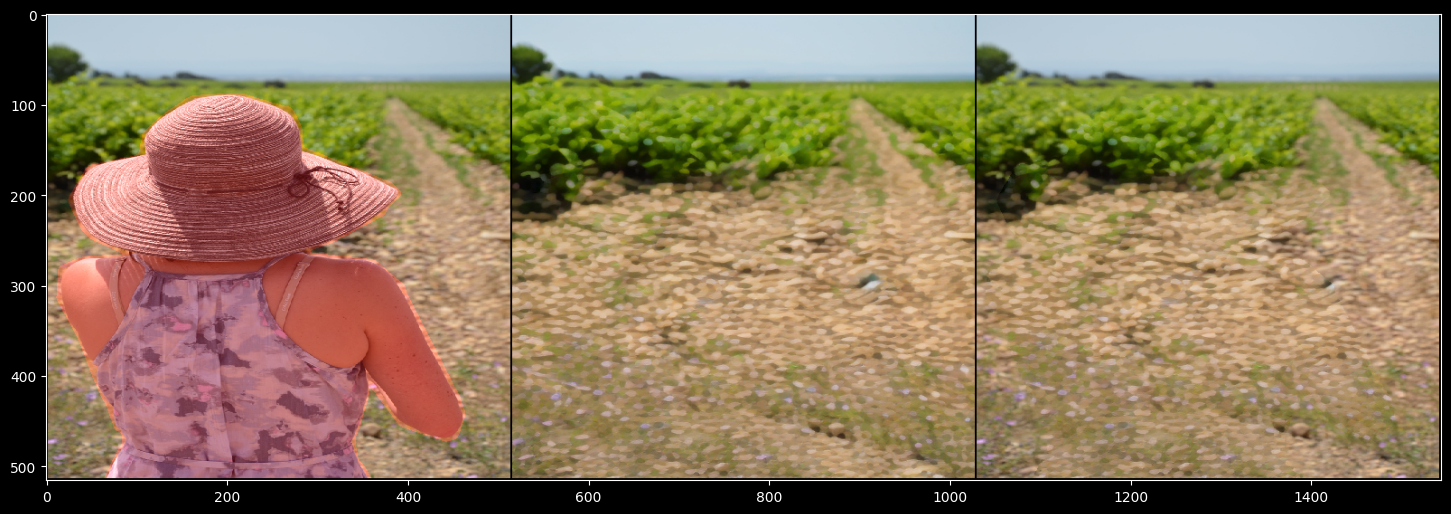

In [32]:
out_tile = mask * image[-1:] + (1 - mask) * (source_image* 0.5 + 0.5)
out_tile_1 = mask_blurred * image[-1:] + (1 - mask_blurred) * out_tile
#out_image = torch.concat([source_image* 0.5 + 0.5,
out_image = torch.concat([img_redder.unsqueeze(0),
                         image[-1:],
                         out_tile_1],
                         #image[:1]],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
#save_image(out_image[2], os.path.join(out_dir, f"compare_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 24))
plt.imshow(img_ori)

In [33]:
""" out_image = torch.cat([source_image * 0.5 + 0.5,
                       image[0:1],
                       image[-1:]], dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))

print("Syntheiszed images are saved in", out_dir)

img_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_ori) """



' out_image = torch.cat([source_image * 0.5 + 0.5,\n                       image[0:1],\n                       image[-1:]], dim=0)\nsave_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))\n\nprint("Syntheiszed images are saved in", out_dir)\n\nimg_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))\nimg_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)\nplt.figure(figsize=(6, 6))\nplt.imshow(img_ori) '

In [34]:
""" out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_withBPF/pred_x0_steps"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for i in range(len(pred_x0_list_denoise)):
    save_image(pred_x0_list_denoise[i], os.path.join(out_dir, f"pred_x0_step{i+1}.png")) """

' out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_withBPF/pred_x0_steps"\nif not os.path.exists(out_dir):\n    os.makedirs(out_dir)\nfor i in range(len(pred_x0_list_denoise)):\n    save_image(pred_x0_list_denoise[i], os.path.join(out_dir, f"pred_x0_step{i+1}.png")) '

In [35]:
""" out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_withBPF/latents_steps"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for i in range(len(latents_list_denoise)):
    save_image(latents_list_denoise[i], os.path.join(out_dir, f"latents_step{i+1}.png")) """

' out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_withBPF/latents_steps"\nif not os.path.exists(out_dir):\n    os.makedirs(out_dir)\nfor i in range(len(latents_list_denoise)):\n    save_image(latents_list_denoise[i], os.path.join(out_dir, f"latents_step{i+1}.png")) '

In [36]:
""" fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    #vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in latents_list_denoise[41:51]]
    vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in pred_x0_list_denoise[20:30]]
    ax.imshow((vl[i]*255).astype(np.uint8))
    ax.axis('off')
plt.show() """

" fig, axs = plt.subplots(2, 5, figsize=(15, 6))\nfor i, ax in enumerate(axs.flatten()):\n    #vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in latents_list_denoise[41:51]]\n    vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in pred_x0_list_denoise[20:30]]\n    ax.imshow((vl[i]*255).astype(np.uint8))\n    ax.axis('off')\nplt.show() "